In [1]:
#필요한 모드 임포트
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from PIL import Image

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#이미지 파일경로 저장 및 데이터 라벨링
dir_ = Path('C:/Users/alstn/Desktop/153.반려동물 안구질환 데이터/01.데이터/1.Training/원천데이터/TS1/개/안구/일반')
test_dir_ = Path('C:/Users/alstn/Desktop/153.반려동물 안구질환 데이터/01.데이터/2.Validation/원천데이터/VS/개/안구/일반/')

import glob
types = ('**/*.jpg', '**/*.png','**/*.jpeg') # the tuple of file types
files_grabbed = []
test_files_grabbed = []
for files in types:
    files_grabbed.extend(dir_.glob(files))
    test_files_grabbed.extend(test_dir_.glob(files))
    
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = []
    for i in range(len(filepath)):
        if(str(filepath[i]).split("\\")[-2] == '무'):
            labels.append(str(filepath[i]).split("\\")[-2])
        else:
            labels.append(str(filepath[i]).split("\\")[-3])

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
             
    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(files_grabbed)
test_df = proc_img(test_files_grabbed)
df.head(5)

,Filepath,Label
0,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,백내장
1,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,백내장
2,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,무
3,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,결막염
4,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,무


In [3]:
test_df.head(5)

,Filepath,Label
0,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,비궤양성각막질환
1,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,무
2,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,궤양성각막질환
3,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,백내장
4,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,무


In [4]:
#데이터 라벨링된 결과
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}\n')

#데이터 라벨링된 결과
print(f'Number of pictures: {test_df.shape[0]}\n')
print(f'Number of different labels: {len(test_df.Label.unique())}\n')
print(f'Labels: {test_df.Label.unique()}')

Number of pictures: 176815

Number of different labels: 11

Labels: ['백내장' '무' '결막염' '궤양성각막질환' '안검내반증' '안검종양' '색소침착성각막염' '유루증' '안검염' '핵경화'
 '비궤양성각막질환']

Number of pictures: 22058

Number of different labels: 11

Labels: ['비궤양성각막질환' '무' '궤양성각막질환' '백내장' '색소침착성각막염' '유루증' '결막염' '핵경화' '안검내반증'
 '안검종양' '안검염']


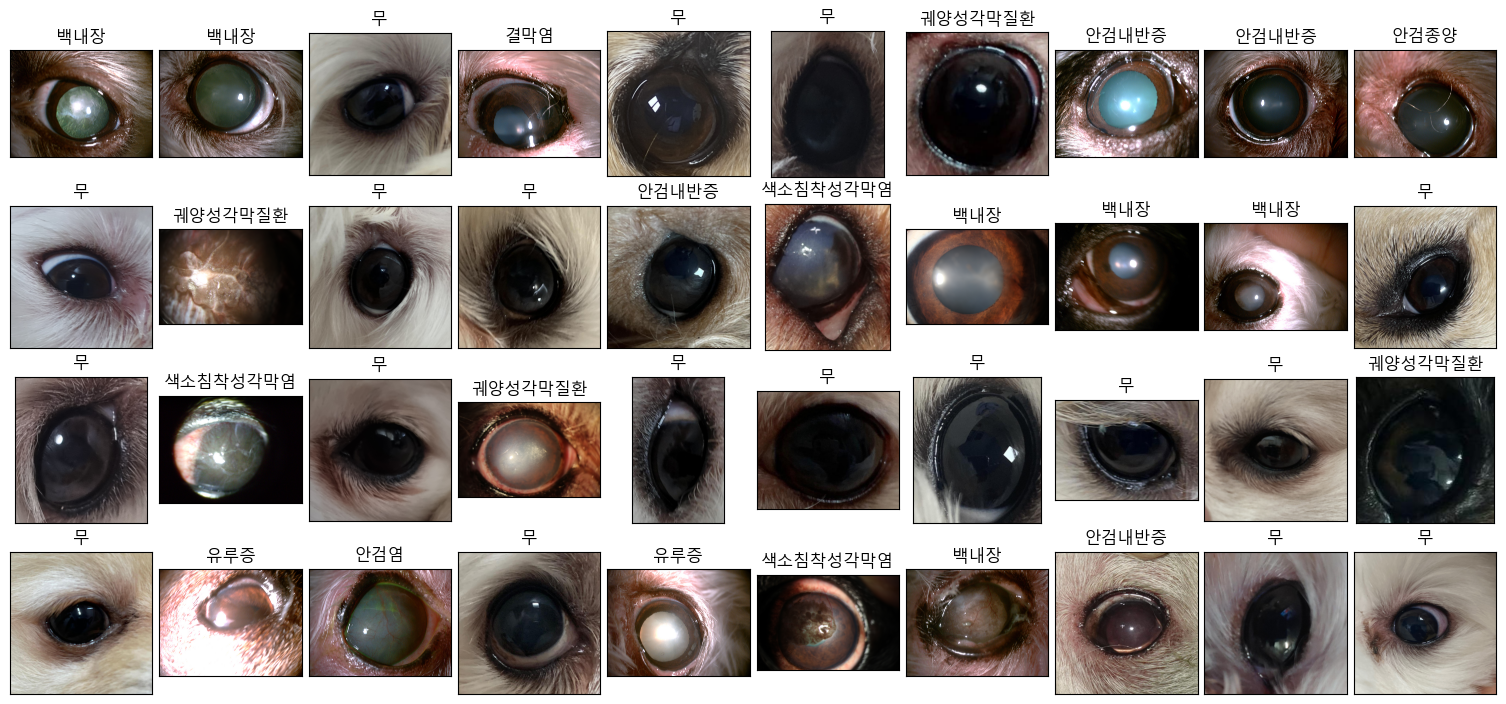

In [5]:
#사진들의 라벨링된 결과를 확인하기 위해 이미지 출력
plt.rc("font", family="Malgun Gothic")

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

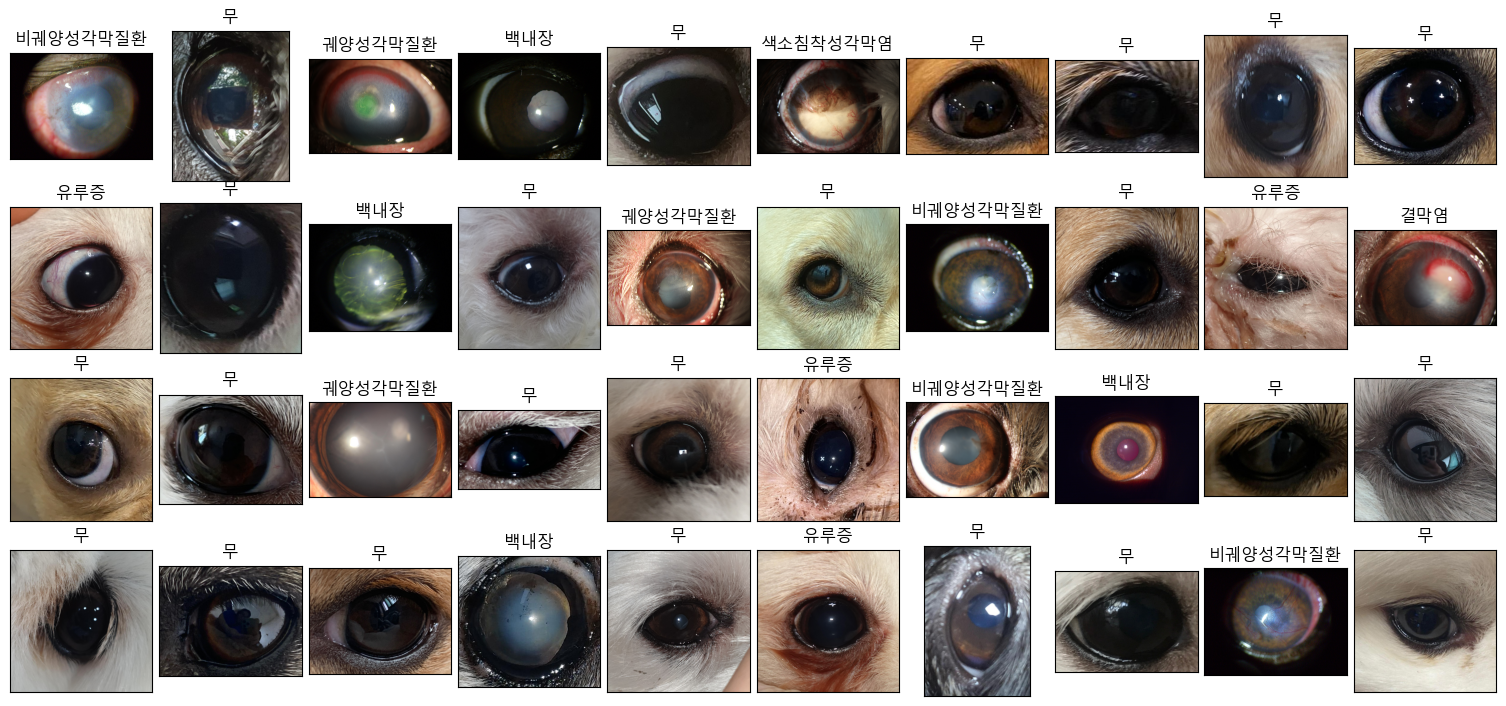

In [6]:
#사진들의 라벨링된 결과를 확인하기 위해 이미지 출력
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(test_df.Filepath[i]))
    ax.set_title(test_df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

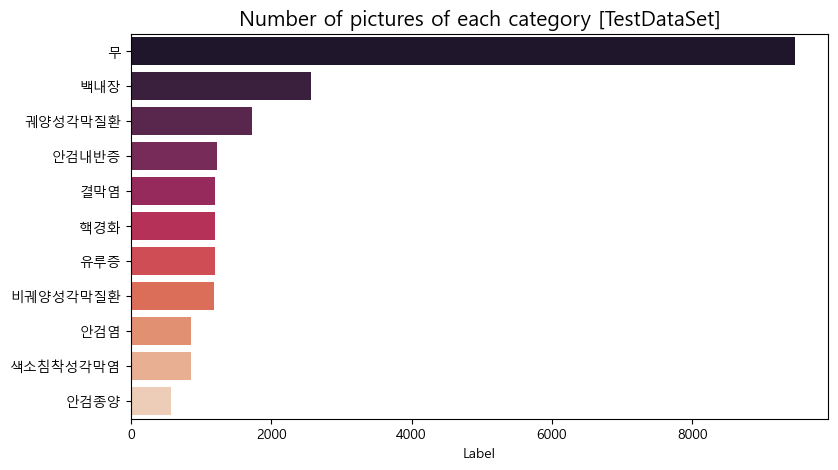

In [7]:
#다이어그램으로 확인
vc = test_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc, y = vc.index, palette = "rocket",orient='h')
plt.title("Number of pictures of each category [TestDataSet]", fontsize = 15)
plt.show()

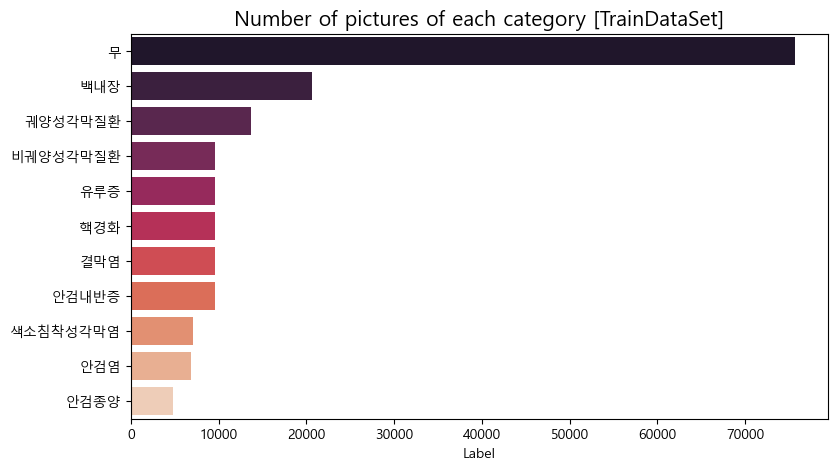

In [8]:
#다이어그램으로 확인
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc, y = vc.index, palette = "rocket",orient='h')
plt.title("Number of pictures of each category [TrainDataSet]", fontsize = 15)
plt.show()

In [9]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=11, activation='softmax')
    ])
    model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
    return model

In [10]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_v2.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]


train_generator,test_generator,train_images,val_images,test_images=create_gen()
with tf.device('/GPU:0'):
    model = get_model() #가장 좋은 성과를 낸 모델을 사용
    history = model.fit(train_images,validation_data=val_images,epochs=10,callbacks=callbacks)

Found 141452 validated image filenames belonging to 11 classes.
Found 35363 validated image filenames belonging to 11 classes.
Found 22058 validated image filenames belonging to 11 classes.
Epoch 1/10
4421/4421 [==============================] - 4293s 966ms/step - loss: 1.2330 - accuracy: 0.5751 - val_loss: 1.0978 - val_accuracy: 0.6054
Epoch 2/10
4421/4421 [==============================] - 4400s 995ms/step - loss: 1.0961 - accuracy: 0.6082 - val_loss: 1.0312 - val_accuracy: 0.6299
Epoch 3/10
4421/4421 [==============================] - 4433s 1s/step - loss: 1.0370 - accuracy: 0.6259 - val_loss: 0.9968 - val_accuracy: 0.6372
Epoch 4/10
4421/4421 [==============================] - 4249s 961ms/step - loss: 0.9956 - accuracy: 0.6378 - val_loss: 0.9763 - val_accuracy: 0.6431
Epoch 5/10
4421/4421 [==============================] - 4174s 944ms/step - loss: 0.9646 - accuracy: 0.6483 - val_loss: 0.9702 - val_accuracy: 0.6417
Epoch 6/10
4421/4421 [==============================] - 4174s 944ms/

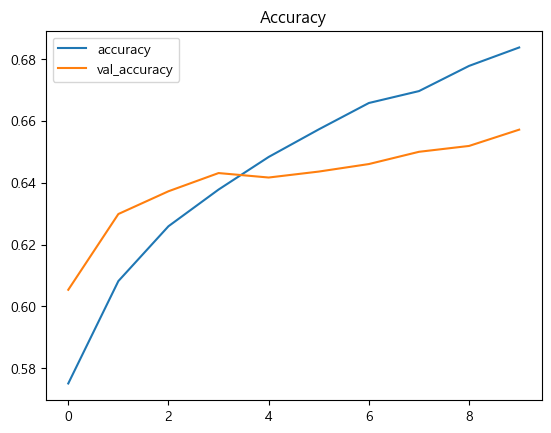

In [11]:
#정확도
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

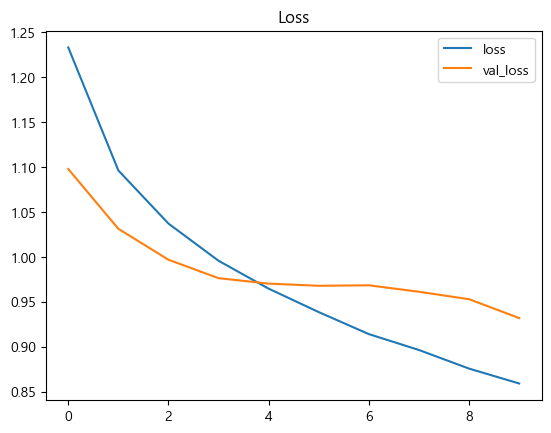

In [12]:
#손실도
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()